##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Importing TensorFlow, Matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Downloading the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


### Image Normalization
In computer vision, the pixel normalization technique is often used to speed up model learning. The normalization of an image consists in dividing each of its pixel values by the maximum value that a pixel can take (255 for an 8-bit image, 4095 for a 12-bit image, 65 535 for a 16-bit image).

In [ ]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
print(f"Shape of training images array: {train_images.shape}")
print(f"Shape of test images array: {test_images.shape}")

Shape of training images array: (50000, 32, 32, 3)
Shape of test images array: (10000, 32, 32, 3)


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


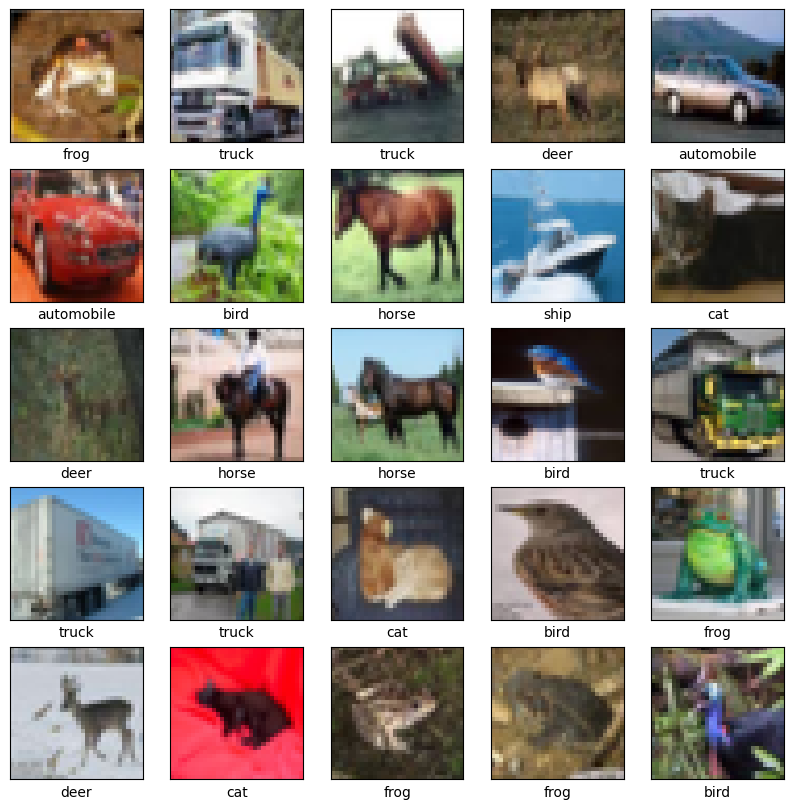

0 5000 images
1 5000 images
2 5000 images
3 5000 images
4 5000 images
5 5000 images
6 5000 images
7 5000 images
8 5000 images
9 5000 images
0 1000 images
1 1000 images
2 1000 images
3 1000 images
4 1000 images
5 1000 images
6 1000 images
7 1000 images
8 1000 images
9 1000 images


In [ ]:
# Define class names for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
number_of_classes = len(class_names)

# Create a figure to display the first 25 images from the training set
plt.figure(figsize=(10, 10))

# Loop through the first 25 images
for i in range(25):
    # Create a subplot with 5 rows and 5 columns
    plt.subplot(5, 5, i + 1)

    # Remove x and y axis ticks
    plt.xticks([])
    plt.yticks([])

    # Turn off grid lines
    plt.grid(False)

    # Display the image from the training set
    plt.imshow(train_images[i])

    # Add label to the subplot using the corresponding class name
    # The CIFAR labels are arrays, hence the extra index [0]
    plt.xlabel(class_names[train_labels[i][0]])

# Show the plot
plt.show()

# Display the distribution of classes using NumPy
unique_classes, counts = np.unique(train_labels.squeeze(), return_counts=True)
for category, size in zip(unique_classes, counts):
    print(f"{category} {size} images")

# Display the distribution of classes using NumPy
unique_classes, counts = np.unique(test_labels.squeeze(), return_counts=True)
for category, size in zip(unique_classes, counts):
    print(f"{category} {size} images")

## Model 1 as given
### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. When using Conv2D layer as the first layer in a model, provide the keyword argument input_shape, e.g. input_shape=(32, 32, 3). You can use None when a dimension has variable size. In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.

#### Conv2D layers
[Referred site](https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)
The first required Conv2D parameter is the number of filters that the convolutional layer will learn.

Layers early in the network architecture (i.e., closer to the actual input image) learn fewer convolutional filters while layers deeper in the network (i.e., closer to the output predictions) will learn more filters.

The second required parameter you need to provide to the Keras Conv2D class is the kernel_size , a 2-tuple specifying the width and height of the 2D convolution window.

The kernel_size must be an odd integer as well. Typical values for kernel_size include: (1, 1) , (3, 3) , (5, 5) , (7, 7) . It’s rare to see kernel sizes larger than 7×7.

#### MaxPooling Layers
Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, (1, 1), padding="SAME", activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding="SAME", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (5, 5), padding="SAME", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (1, 1), padding="SAME", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding="SAME", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (5, 5), padding="SAME", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (1, 1), padding="SAME", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), padding="SAME", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (5, 5), padding="SAME", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10))

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification.

Dense is just a regularly densely connected NN layer, implements the operation: output = activation(dot(input, kernel) + bias) (operation of the perceptron) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer. These are all attributes of Dense.

Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

Here's the complete architecture of your model:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        256       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model
This model uses an Optimizer that implements the Adam algorithm. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

The number of epochs is a hyperparameter that defines how many times the learning algorithm will work through the entire training dataset. It's important to choose an appropriate number of epochs to balance between underfitting (too few epochs, not capturing the underlying patterns in the data) and overfitting (too many epochs, fitting the training data too closely and not generalizing well to new, unseen data).

### Evaluate the model

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have your dataset loaded into train_images, train_labels
# Define the number of folds
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define early stopping callback
earlystopper = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Lists to store aggregated predictions and true labels
all_predictions = []
all_true_labels = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(train_images)):
    print(f"Training Fold {fold + 1}...")

    # Split data into train and validation sets
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Train the model on the current fold with class weights
    history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=20, callbacks=[earlystopper], verbose=1)

    # Evaluate the model on the test set or another validation set
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f"Test accuracy for Fold {fold + 1}: {test_acc}")

    # Predict on the validation set or another test set
    fold_predictions = np.argmax(model.predict(X_val), axis=-1)
    all_predictions.extend(fold_predictions)
    all_true_labels.extend(y_val.flatten())

Training Fold 1...
Epoch 1/25
2000/2000 [==============================] - 53s 20ms/step - loss: 1.8954 - accuracy: 0.2908 - val_loss: 1.5092 - val_accuracy: 0.4235
Epoch 2/25
2000/2000 [==============================] - 40s 20ms/step - loss: 1.5325 - accuracy: 0.4355 - val_loss: 1.3234 - val_accuracy: 0.5422
Epoch 3/25
2000/2000 [==============================] - 41s 20ms/step - loss: 1.3345 - accuracy: 0.5275 - val_loss: 1.0850 - val_accuracy: 0.6323
Epoch 4/25
2000/2000 [==============================] - 43s 22ms/step - loss: 1.1812 - accuracy: 0.5956 - val_loss: 0.9734 - val_accuracy: 0.6815
Epoch 5/25
2000/2000 [==============================] - 41s 20ms/step - loss: 1.0484 - accuracy: 0.6426 - val_loss: 0.9088 - val_accuracy: 0.7011
Epoch 6/25
2000/2000 [==============================] - 41s 21ms/step - loss: 0.9607 - accuracy: 0.6775 - val_loss: 0.7711 - val_accuracy: 0.7448
Epoch 7/25
2000/2000 [==============================] - 41s 21ms/step - loss: 0.8858 - accuracy: 0.7077 -

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# Predictions
predictions = np.argmax(model.predict(test_images), axis=-1)

# Convert test_labels to 1D array if not already
test_labels_flat = test_labels.flatten()

# Print accuracy
print("Test accuracy:", test_acc)

313/313 - 2s - loss: 0.4952 - accuracy: 0.8490 - 2s/epoch - 7ms/step
313/313 [==============================] - 2s 6ms/step
Test accuracy: 0.8489999771118164


In [ ]:
# Print classification report
print("Overall Classification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=class_names))

# Print confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print(conf_matrix)

Overall Classification Report:
              precision    recall  f1-score   support

    airplane       0.93      0.94      0.93      5000
  automobile       0.97      0.97      0.97      5000
        bird       0.89      0.89      0.89      5000
         cat       0.79      0.85      0.82      5000
        deer       0.92      0.92      0.92      5000
         dog       0.87      0.83      0.85      5000
        frog       0.96      0.93      0.95      5000
       horse       0.95      0.94      0.95      5000
        ship       0.96      0.96      0.96      5000
       truck       0.97      0.96      0.96      5000

    accuracy                           0.92     50000
   macro avg       0.92      0.92      0.92     50000
weighted avg       0.92      0.92      0.92     50000

Confusion Matrix:
[[4694   13   82   37   15    5    6   14  110   24]
 [  19 4832    3   19    1    3    4    2   29   88]
 [ 150    3 4426  124   98   73   79   31   10    6]
 [  40    4  134 4262   67  372  

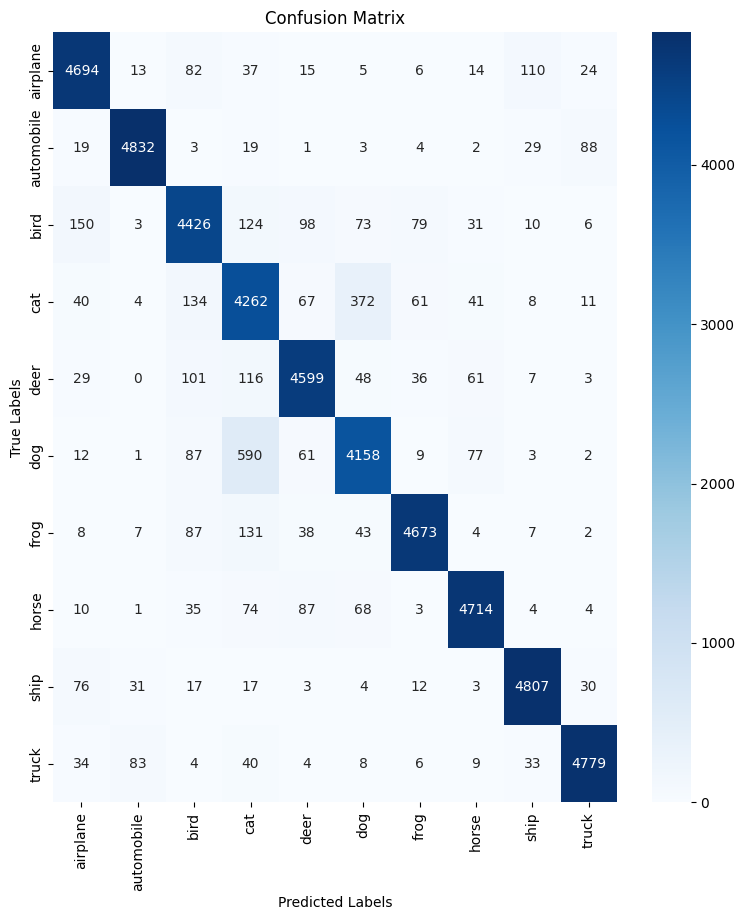

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(20, 10))  # Set the figure size
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
#plt.colorbar()

plt.show()

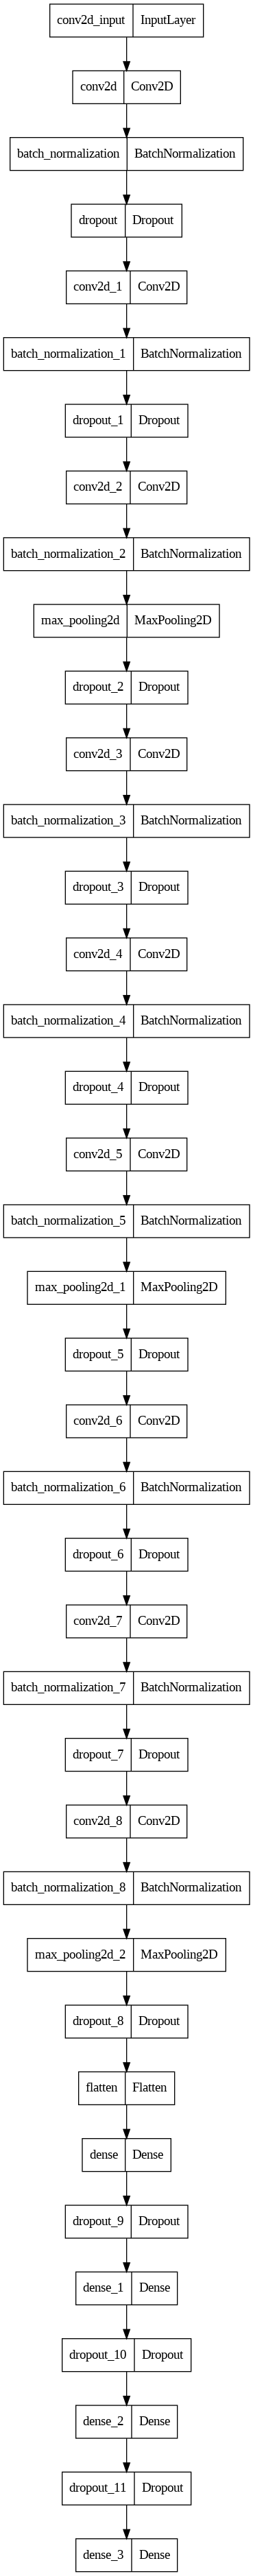

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)